In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda, Dropout, BatchNormalization
from keras import regularizers, losses
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from tensorflow.keras.losses import MeanSquaredError
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import os

In [2]:
# Utility functions
def pclip(p):
    "§""Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
    max_half_life = 274.0   
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)


In [3]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

In [4]:
# Total
# cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'ui_language', 'learning_language', 'h_recall']

# - LEX - U features
# cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'ui_language', 'learning_language', 'h_recall', 'avg_delta', 'std_delta', 'avg_h_recall', 'tags_list',
#                 'gender', 'SUBTLEX', 'def', 'tense', 'POS', 'person', 'number', 'word_len']


# - LEX
cols_to_drop=['tags_list', 'word_len', 'SUBTLEX', 'gender', 'def', 'tense', 'POS', 'person', 'number', 'learning_language', 'timestamp', 'user_id', 'word',
              'ui_language', 'h_recall', 'lexeme_id']


dff.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [5]:
dff.head()

,p_recall,delta,history_seen,history_correct,session_seen,session_correct,lang_combination,avg_delta,std_delta,avg_h_recall
0,1.0,27649635,6,4,2,2,en-de,6.245869e+06,1.175043e+07,0.884367
1,1.0,5963,8,6,6,6,en-de,6.245869e+06,1.175043e+07,0.884367
2,0.0,253,14,12,1,0,en-de,6.245869e+06,1.175043e+07,0.884367
3,1.0,65,15,12,1,1,en-de,6.245869e+06,1.175043e+07,0.884367
4,0.5,27,16,13,2,1,en-de,6.245869e+06,1.175043e+07,0.884367


In [6]:
# columns transformation

# total
# dff['delta'] = np.log2(dff['delta']/(60*60*24)) # convert time delta to days
# dff['avg_delta'] = np.log2(dff['avg_delta']/(60*60*24)) 
# dff['std_delta'] = np.log2(dff['std_delta']/(60*60*24)+1e-10)
# dff['p_recall'] = pclip(dff['p_recall'])
# dff['history_seen'] = np.log2((1+dff['history_seen']))
# dff['history_correct'] = np.log2(1+dff['history_correct'])
# dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))
# dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

# -lex -u
# dff['p_recall'] = pclip(dff['p_recall'])
# dff['history_seen'] = np.log2((1+dff['history_seen']))
# dff['history_correct'] = np.log2(1+dff['history_correct'])
# dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))
# dff['delta'] = np.log2(dff['delta']/(60*60*24)) # convert time delta to days


# - lex 
dff['p_recall'] = pclip(dff['p_recall'])
dff['history_seen'] = np.log2((1+dff['history_seen']))
dff['history_correct'] = np.log2(1+dff['history_correct'])
dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))
dff['delta'] = np.log2(dff['delta']/(60*60*24)) # convert time delta to days
dff['avg_delta'] = np.log2(dff['avg_delta']/(60*60*24)) 
dff['std_delta'] = np.log2(dff['std_delta']/(60*60*24)+1e-10)

# dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))


In [7]:
dff

,p_recall,delta,history_seen,history_correct,session_seen,session_correct,lang_combination,avg_delta,std_delta,avg_h_recall,half_life
0,0.9999,8.322013,2.807355,2.321928,2,2,en-de,6.175727,7.087467,0.884367,274.000000
1,0.9999,-3.856921,3.169925,2.807355,6,6,en-de,6.175727,7.087467,0.884367,274.000000
2,0.0001,-8.415750,3.906891,3.700440,1,0,en-de,6.175727,7.087467,0.884367,19.040147
3,0.9999,-10.376376,4.000000,3.700440,1,1,en-de,6.175727,7.087467,0.884367,274.000000
4,0.5000,-11.643856,4.087463,3.807355,2,1,en-de,6.175727,7.087467,0.884367,27.000000
...,...,...,...,...,...,...,...,...,...,...,...
12707771,0.0001,-3.720804,2.000000,1.584963,1,0,en-pt,0.570385,2.448109,0.928925,274.000000
12707772,0.9999,-3.720804,1.584963,1.000000,1,1,en-pt,0.570385,2.448109,0.928925,274.000000
12707773,0.9999,0.738588,2.321928,1.000000,1,1,en-it,3.509147,4.177588,0.876621,274.000000
12707774,0.9999,7.523187,1.000000,1.000000,3,3,en-de,7.184434,5.897634,0.782869,274.000000


In [8]:

# total 
categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()
dff[categorical_cols] = dff[categorical_cols].fillna('missing')
# dff.drop(columns=['tags_list'], inplace=True)

In [9]:
def scale_dataset(df):
    categorical_features = df.select_dtypes(include='O').columns
    numeric_features = df.select_dtypes(exclude=['O']).columns.drop(['p_recall', 'half_life', 'delta', 'session_seen', 'session_correct'])

    scaler = MinMaxScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df, categorical_features, numeric_features

In [10]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded



dff.dropna(inplace=True)
df_final = ohe(dff)
df_final, categorical_features, numeric_features = scale_dataset(df_final)

In [11]:
df_final = df_final.sample(frac=1)

In [12]:
def split_dataset(df):
    X = df.drop(columns=['p_recall', 'half_life'])
    y = df[['p_recall', 'half_life']]
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    
    X_test_session = X_test[['session_seen', 'session_correct']]
    X_test.drop(columns=['session_seen', 'session_correct'], inplace=True)
    X_train.drop(columns=['session_seen', 'session_correct'], inplace=True)

    X_train_delta = X_train['delta']
    X_train_numerical = X_train.drop(columns=['delta'])

    X_test_delta = X_test['delta']
    X_test_numerical = X_test.drop(columns=['delta'])


    
    y_train_p_recall = y_train['p_recall']
    y_train_half_life = y_train['half_life']
    y_test_p_recall = y_test['p_recall']
    y_test_half_life = y_test['half_life']
    
    return X_train_numerical, X_train_delta, X_test_numerical, X_test_delta, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session



In [13]:
X_train_numerical, X_train_delta, X_test_numerical, X_test_delta, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session = split_dataset(df_final)

In [14]:
# Sizes match
# print('X_train_tags_size', X_train_tags.shape)
# print('X_train_langs_size', X_train_langs.shape)
# print('X_train_numerical_size', X_train_numerical.shape)
# print('X_test_tags_size', X_test_tags.shape)
# print('X_test_langs_size', X_test_langs.shape)
# print('X_test_numerical_size', X_test_numerical.shape)
# print('y_train_half_life_size', y_train_half_life.shape)
# print('y_train_p_recall_size', y_train_p_recall.shape)
# print('y_test_half_life_size', y_test_half_life.size)
# print('y_test_p_recall_size', y_test_p_recall.size)

In [15]:
# Custom weights
# def compute_custom_weights(y, num_bins = 5): 
#     bins = np.quantile(y, np.linspace(0, 1, num_bins + 1))
#     bin_indices = np.digitize(y, bins, right=True)
#     bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)
#     bin_freqs = bin_counts / len(y)

#     # Assign inverse weights
#     bin_weights = 1 / (bin_freqs + 1e-6) 
#     sample_weights = bin_weights[bin_indices]
#     return sample_weights

# sample_weights = compute_custom_weights(y_train_p_recall)

In [16]:
# alpha = 0.5  # or whatever value you set in the thesis

# def nhlr_loss(y_true, y_pred):
#     h_true, p_true = y_true
#     h_pred, p_pred = y_pred

#     slh = tf.reduce_mean(tf.square(h_true - h_pred))
#     slp = tf.reduce_mean(tf.square(p_true - p_pred))

#     return slp + alpha * slh

In [17]:
# NHLR LOSS PREVIOUS

def nhlr_loss(y_true, y_pred):
    h_true, p_true = y_true[0], y_true[1]
    h_pred, p_pred = y_pred[0], y_pred[1]

    slh = tf.reduce_mean(tf.square(h_true - h_pred)) # half-life loss 
    slp = tf.reduce_mean(tf.square(p_true - p_pred)) # p_recall loss 

    return slp + 0.1 * slh 

In [18]:
numerical_shape = X_train_numerical.shape[1]

def train_model(hidden_dim=16, l2wt=0.01, learning_rate=0.001, dropout_rate=0.5, batch_size=64):
    numerical_input = Input(shape=(numerical_shape,), name='numerical_input')
    delta_input = Input(shape=(1,), name='delta_input')

    x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(numerical_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
        
    half_life_output = Dense(1, activation="relu", name="half_life", bias_initializer=tf.keras.initializers.Constant(0.1))(x) 
    
    p_recall_output = Lambda(
        lambda inputs: tf.clip_by_value(tf.pow(2.0, -tf.maximum(inputs[0], 0.0) / tf.maximum(inputs[1], 1e-3)), 1e-4, 1.0), 
        name="p_recall")([delta_input, half_life_output])
    
    
    model = Model(inputs=[numerical_input, delta_input], outputs=[half_life_output, p_recall_output])
    model.compile(loss=nhlr_loss, optimizer= Adam(learning_rate=learning_rate), metrics=['MAE', 'MAE'])
    return model


model = train_model(hidden_dim=32, l2wt=0.001, learning_rate=0.001, dropout_rate=0.5, batch_size=64)

model.fit([X_train_numerical, X_train_delta], [y_train_half_life, y_train_p_recall], epochs=10, verbose=2)
model.summary()

Epoch 1/10
317462/317462 - 140s - 442us/step - half_life_MAE: 41.6104 - half_life_loss: 4033.8796 - loss: 4034.0388 - p_recall_MAE: 0.1074 - p_recall_loss: 0.0935
Epoch 2/10
317462/317462 - 140s - 442us/step - half_life_MAE: 33.4950 - half_life_loss: 2700.0525 - loss: 2700.3181 - p_recall_MAE: 0.1057 - p_recall_loss: 0.0914
Epoch 3/10
317462/317462 - 141s - 443us/step - half_life_MAE: 28.3379 - half_life_loss: 2242.6433 - loss: 2243.0857 - p_recall_MAE: 0.1056 - p_recall_loss: 0.0915
Epoch 4/10
317462/317462 - 140s - 442us/step - half_life_MAE: 23.9458 - half_life_loss: 1903.7560 - loss: 1904.5194 - p_recall_MAE: 0.1056 - p_recall_loss: 0.0916
Epoch 5/10
317462/317462 - 141s - 443us/step - half_life_MAE: 20.3638 - half_life_loss: 1704.8539 - loss: 1706.2308 - p_recall_MAE: 0.1056 - p_recall_loss: 0.0918
Epoch 6/10
317462/317462 - 140s - 441us/step - half_life_MAE: 17.5541 - half_life_loss: 1571.6735 - loss: 1574.1112 - p_recall_MAE: 0.1056 - p_recall_loss: 0.0918
Epoch 7/10
317462/3174

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        448 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_life (Dense)   │ (None, 1)         │         33 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_recall (Lambda)   │ (None, 1)         │          0 │ delta_input[0][0… │
│                     │                   │            │ half_life[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,701 (6.65 KB)

 Trainable params: 545 (2.13 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,092 (4.27 KB)

In [19]:
# Sizes match

# print("Max tag index:", X_train_tags.max(), "Embedding input_dim:", len_tags)
# print("Max lang index:", X_train_langs.max(), "Embedding input_dim:", len_langs)

# print("Tags Input Shape:", tags_input.shape)
# print("Langs Input Shape:", langs_input.shape)
# print("Numerical Input Shape:", numerical_input.shape)

# print("Flattened tags Embedded Shape:", flattened_tags.shape)
# print("Flattened Langs Embedded Shape:", flattened_langs.shape)
# # print("Flattened Numerical Input Shape:", numerical_input.shape)

# print("X_train_tags shape:", X_train_tags.shape)    
# print("X_train_langs shape:", X_train_langs.shape)  
# print("X_train_numerical shape:", X_train_numerical.shape)  
# print("X_train_delta shape:", X_train_delta.shape)  
# print('X_test numerical shape:', X_test_numerical.shape)  # Expected: (num_samples, 178), but you have (num_samples, 176)
# print('X_test delta shape:', X_test_delta.shape)   # Ensure it matches the expected shape
# print('input df shape', df_final.shape)

# print(y_train_half_life.shape)
# print(y_train_p_recall.shape)


In [20]:
y_pred_half_life, y_pred_p_recall  = model.predict([X_test_numerical, X_test_delta])

79366/79366 ━━━━━━━━━━━━━━━━━━━━ 16s 197us/step


In [21]:
print('Test MAE:', mean_absolute_error(y_test_p_recall, y_pred_p_recall))

Test MAE: 0.10569459860521635


In [22]:
df_results = X_test_session.copy()
df_results['p_recall'] = y_test_p_recall
df_results['p_recall_pred'] = y_pred_p_recall
df_results['diff'] = df_results['p_recall'] - df_results['p_recall_pred']
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
10411471,1.0,1.0,0.9999,0.982730,0.017170
8971899,2.0,2.0,0.9999,1.000000,-0.000100
7115393,1.0,1.0,0.9999,0.997279,0.002621
2452753,1.0,1.0,0.9999,0.995925,0.003975
8244144,1.0,1.0,0.9999,0.989955,0.009945
...,...,...,...,...,...
8145710,1.0,1.0,0.9999,1.000000,-0.000100
2963898,5.0,5.0,0.9999,1.000000,-0.000100
8678007,2.0,2.0,0.9999,0.997548,0.002352
11963198,1.0,1.0,0.9999,0.993649,0.006251


In [23]:
df_results.sort_values(by='diff')
df_results.head()

,session_seen,session_correct,p_recall,p_recall_pred,diff
10411471,1.0,1.0,0.9999,0.982730,0.017170
8971899,2.0,2.0,0.9999,1.000000,-0.000100
7115393,1.0,1.0,0.9999,0.997279,0.002621
2452753,1.0,1.0,0.9999,0.995925,0.003975
8244144,1.0,1.0,0.9999,0.989955,0.009945


In [24]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results.describe()

,session_seen,session_correct,p_recall,p_recall_pred,diff
count,2539690.00000,2539690.00000,2539690.00000,2539690.00000,2539690.00000
mean,1.81538,1.64259,0.89639,0.99660,-0.10021
std,1.35856,1.31693,0.27097,0.00483,0.27080
min,1.00000,0.00000,0.00010,0.97717,-0.99990
25%,1.00000,1.00000,0.99990,0.99385,-0.00010
50%,1.00000,1.00000,0.99990,1.00000,-0.00010
75%,2.00000,2.00000,0.99990,1.00000,0.00476
max,20.00000,20.00000,0.99990,1.00000,0.02270


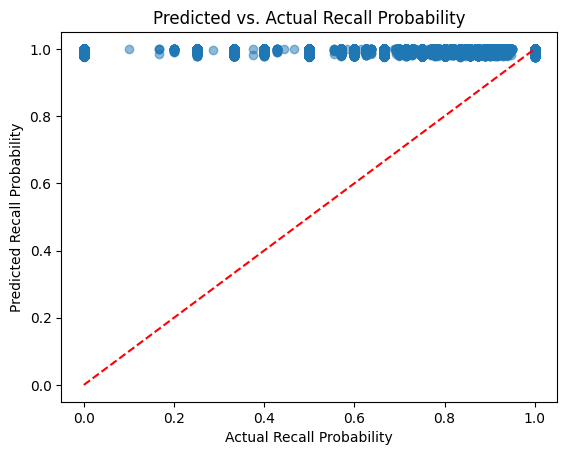

In [25]:
# Predicted vs Actual 
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))

    
pred_scatterplot = plt.scatter(df_results['p_recall'], df_results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
pred_scatterplot.figure.savefig(out_filepath('visualizations/HNN_predictions_scatterplot.png'))


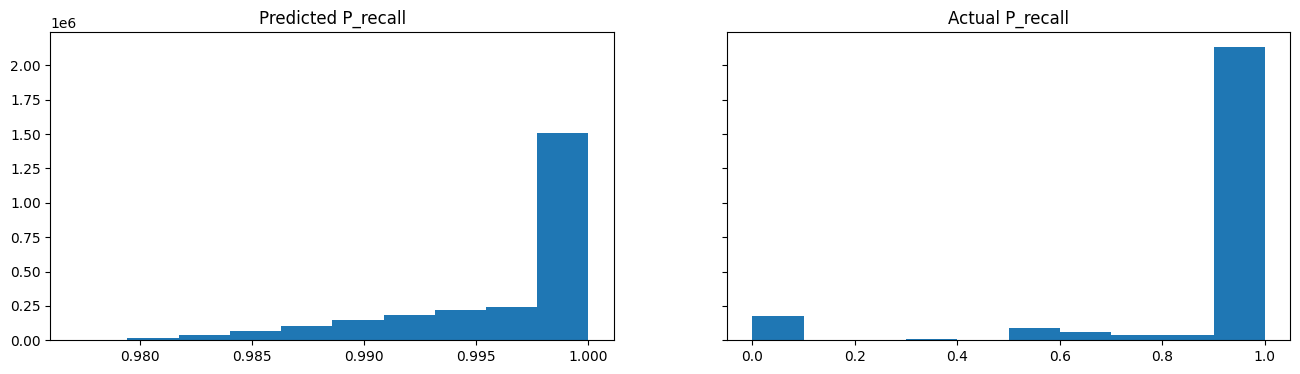

In [26]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(df_results['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(df_results['p_recall_pred'])
p_recall_histogram.set_size_inches(16, 4)

In [27]:
expanded_df = df_results.loc[df_results.index.repeat(df_results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(df_results["session_seen"], df_results["session_correct"])
])

In [28]:
expanded_df.head()

,session_seen,session_correct,p_recall,p_recall_pred,diff,outcome
0,1.00000,1.00000,0.99990,0.98273,0.01717,1.00000
1,2.00000,2.00000,0.99990,1.00000,-0.00010,1.00000
2,2.00000,2.00000,0.99990,1.00000,-0.00010,1.00000
3,1.00000,1.00000,0.99990,0.99728,0.00262,1.00000
4,1.00000,1.00000,0.99990,0.99593,0.00397,1.00000


In [31]:
%run diagnostics.ipynb


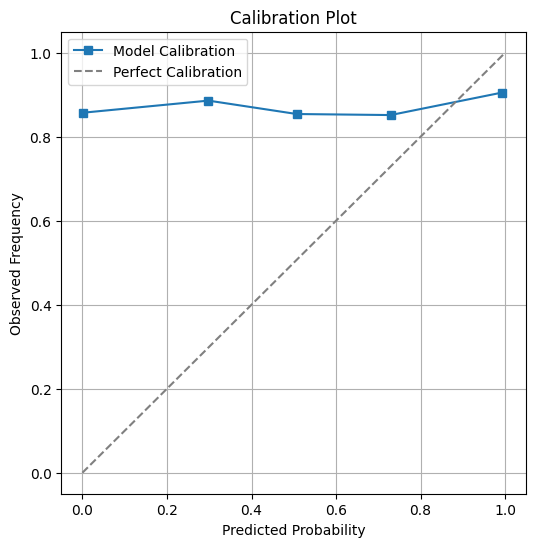

In [216]:

plot_calibration(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_calibration_plot.png')

AUC Score: 0.5303


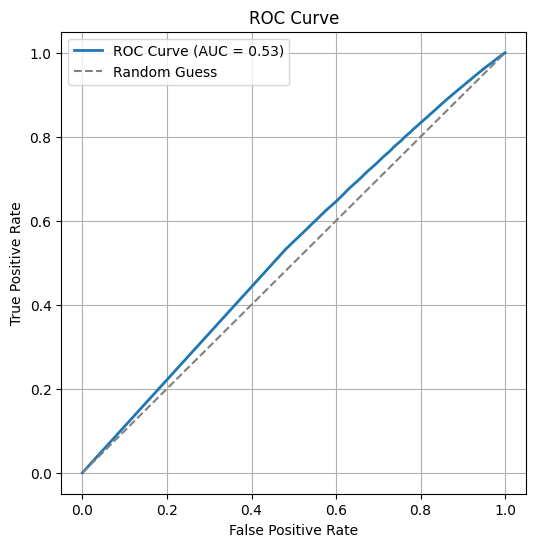

In [32]:
AUC_ROC(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_ROC_plot_lex_u.png')

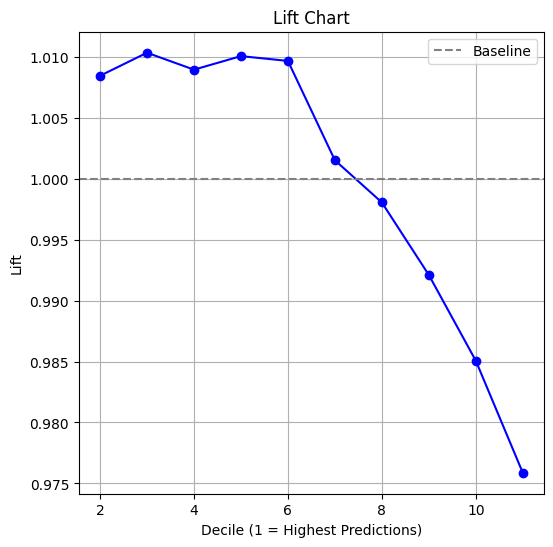

In [218]:
plot_lift(expanded_df, 'outcome', expanded_df['p_recall_pred'], 'HNN_lift_plot.png')

In [219]:
hnn = expanded_df.drop(columns=['session_seen', 'session_correct'])

filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
hnn.to_csv(os.path.join(filepath, 'hnn_output.csv'), sep='\t', index=False, header=True)